In [1]:
'''
assume exponential utility and Gaussian distribution, here is a simplfied neural network to learn the fair measure transformation
based on dual problem and alpha is given by 3.2
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy import random
from scipy.stats import multivariate_normal
import pandas as df
import random
import matplotlib.pyplot as plt
import time

np.random.seed(1)
random.seed(1)

# Define a class Gaussian Distribution to Generate the Gaussion Distribution in N-dimensions
class GaussianND:
    # initialize the class
    def __init__(self,n_samples,n_institutions,means,covariance):
        '''
        Input:  n_institutions: number N
              means: list 1 x N
              covariance: 2D array: N x N
        Output: Generate function: n_samples x N 
        '''
        # Initialize the parameters
        self.n_samples = n_samples
        self.N = n_institutions
        self.means = means
        self.covariance = covariance
        # Get the eigen value and eigen vectors, to help generate N-dimensional data
        self.eigen_values, self.eigen_vectors = np.linalg.eig(self.covariance)
    def generate(self):
        component = []
        for i in range(self.n_samples):
            z = np.random.normal(0,1,self.N)
            x = self.means
            #print(x,"\n",self.covariance,"\n",self.eigen_values, "\n",self.eigen_vectors)
            for j in range(self.N):
              x += np.sqrt(self.eigen_values[j])*z[j]*self.eigen_vectors[j]
            component.append(x)
        return component

def generate_sample(n_samples,n_institutions,means,covariance):
    '''
    return np.array: n_samples x n_institutions
    '''
    sample = GaussianND(n_samples,n_institutions,means,covariance).generate()
    #print(sample[0:3])
    #data = df.DataFrame(np.array(sample))#columns= ['Inst 1','Inst 2','Inst 3']
    return np.array(sample)

#generate a random positive semi-definite N*N integer matrix as integer covariace matrix, in [0,m]
def generate_covint(N,m):
    A = np.random.rand(N,N)*m
    D = np.dot(A,A.transpose())
    return D
#convert covariance to correlation matrix and sigma vector: cor = diag^{-1}*cov*diag^{-1}
def func_correlation(cov, N):
    diag = np.zeros((N,N))      #diagonal matrix
    sig = []
    for i in range(N):
        diag[i][i] = cov[i][i]
        sig.append(np.sqrt(cov[i][i]))
    inv_diag_sqrt = np.linalg.inv(np.sqrt(diag))
    #print("covariance\n", cov,"\ndiagnal matrix\n",diag,"\ninverse diag suare root(sigma)\n", inv_diag_sqrt)
    return (np.dot(np.dot(inv_diag_sqrt,cov),inv_diag_sqrt)), sig


# number of sample 
number_of_sample = 50000
##number_of_val = 50
number_of_test = 50000
n_institutions = 10

means = sorted([(random.random()*3+0.1) for i in range(n_institutions)]) #*5+0.1

covariance = generate_covint(n_institutions,1)
cor_mat = func_correlation(covariance, n_institutions)[0]
sig = [random.uniform(0,min(means[i],10)) for i in range(n_institutions)]
covariance = np.dot(np.dot(np.diag(sig),cor_mat),np.diag(sig))
print("Correlation:\n",cor_mat,"\n and Standard deviation: ",sig )

###
'''
covariance = generate_covint(n_institutions,1)
cor_sig = func_correlation(covariance, n_institutions) 
print("Correlation:\n",cor_sig[0],"\n and Standard deviation: ",cor_sig[1] )
'''
'''
means = [0.8,1.2,2]
covariance = np.array([[1,0.63,0.4], [0.63,1,0.35],[0.4,0.35,1]])
'''

train_data = generate_sample(number_of_sample,n_institutions,means,covariance)
##val_data = generate_sample(number_of_val,n_institutions,means,covariance)
test_data = generate_sample(number_of_test,n_institutions,means,covariance)

Correlation:
 [[1.         0.76879721 0.79797391 0.63977286 0.76842207 0.84360741
  0.72712452 0.7690699  0.79973971 0.79321111]
 [0.76879721 1.         0.76460382 0.7065317  0.88868415 0.60437623
  0.73136608 0.71166309 0.82694093 0.81677252]
 [0.79797391 0.76460382 1.         0.68318876 0.73039232 0.71925062
  0.60672877 0.68101638 0.77336207 0.72565569]
 [0.63977286 0.7065317  0.68318876 1.         0.63893002 0.74890436
  0.7769598  0.6763403  0.79445986 0.89226057]
 [0.76842207 0.88868415 0.73039232 0.63893002 1.         0.64305234
  0.69972851 0.84298003 0.79555034 0.78864991]
 [0.84360741 0.60437623 0.71925062 0.74890436 0.64305234 1.
  0.81246161 0.76113303 0.6808991  0.84599023]
 [0.72712452 0.73136608 0.60672877 0.7769598  0.69972851 0.81246161
  1.         0.77072239 0.86664351 0.75449805]
 [0.7690699  0.71166309 0.68101638 0.6763403  0.84298003 0.76113303
  0.77072239 1.         0.76497694 0.70674911]
 [0.79973971 0.82694093 0.77336207 0.79445986 0.79555034 0.6808991
  0.866

In [2]:
means

[0.18504242956601893,
 0.38157876032270466,
 0.5030927323372036,
 0.8652070772182651,
 1.4484731943662146,
 1.586305261275823,
 2.0547789181682887,
 2.391323856929842,
 2.4661700534065396,
 2.642301210811698]

In [3]:
import torch
#import torchvision
#import torchvision.transforms as transforms
#import matplotlib.pyplot as plt
#import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Training on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size=1000
## Tensor Initialization
data_=torch.from_numpy(train_data).to(device)
dataset = torch.utils.data.TensorDataset(data_)
trainloader = torch.utils.data.DataLoader(dataset,batch_size, shuffle = False)
# validation data
##validation_data=torch.from_numpy(val_data).to(device)
# testing data
testdata=torch.from_numpy(test_data).to(device)
dataset = torch.utils.data.TensorDataset(testdata)
testloader = torch.utils.data.DataLoader(dataset,batch_size, shuffle = False)

In [4]:
# NN: Generator, return -alpha_B
class Generator(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        input_dim: number of uniform rvs, i.e. n_institutions 
        hidden_dim: list of hidden layer dimensions
        output_dim: number of classes i.e. n_institutions 
        '''
        super(Generator, self).__init__()
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        
    def residual(self, x):
        for i in range(len(self.model)-1):
          x = torch.relu(self.model[i](x))
        #x=torch.sigmoid(self.model[-1](x))
        #x=F.elu(self.model[-1](x))
        return torch.log(1+torch.exp(self.model[-1](x))) ## different, Z are nonnegative


    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and relu at the output.
        '''
        
        return x + self.residual(x)

class Alpha_Loss(nn.Module):
    def __init__(self,utility,u_parameters, B, lam):
        """
        input:
            dQ_dP: current tranformation, siz M x 1
            utility function: 'exp','...'
            parameter for utitlity function: list of u_paramaters
        """
        super(Alpha_Loss, self).__init__()
        self.u = utility
        self.u_parameters = torch.tensor(u_parameters, device="cuda")
        self.B, self.lam = B, lam
        
    def calculate_u(self, z):
        '''
        input:
          z - tensor(batch, N)
        return:
          tensor(batch), utilitiess or sum of u across N
        '''
        if self.u == 'exp':
          return torch.sum(-torch.exp(-z*self.u_parameters)/self.u_parameters, dim=1)
        
    def forward(self, dQ_dP, Z):
        """
        input:
            Z -- inputs: M x N
        return: value of loss function
        """
        # control lost
        sum_trans_Z = torch.reshape(torch.sum(Z, 1),(-1,1))*dQ_dP
        sum_u = self.calculate_u(Z)
        
        self.term1 = self.B - torch.mean(sum_u)
        self.term2 = torch.mean(sum_trans_Z)
        return torch.mean(sum_trans_Z)  + self.lam*torch.relu(self.B - torch.mean(sum_u))

    def print_loss(self):
        print("B-sum u_n",self.term1.item())
        print("-alpha",self.term2.item())


In [5]:
# Neural Networks: approximate rho
class Net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        uniform tranformation for X_i, thus input 1-d and output 1-d
          input_dim: N
          hidden_dim: list of hidden layer dimensions
          output_dim: 1
        '''
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        

    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and relu at the output.
        '''
        for i in range(len(self.model)-1):
          x = torch.relu(self.model[i](x))
        #x=torch.sigmoid(self.model[-1](x))
        #x=F.elu(self.model[-1](x))
        #x=self.model[-1](x)
        x = torch.log(1+torch.exp(self.model[-1](x)))
        #x = F.leaky_relu(self.model[-1](x),negative_slope=0.05) #+ 0.001
        return x/torch.mean(x)

class Loss(nn.Module):
    def __init__(self, u_paramaters, B):
        super(Loss, self).__init__()
        self.alphas = torch.tensor(u_paramaters).to(device)
        self.B = B
        self.beta = self.calculate_par()

    def calculate_par(self):
        beta = 0
        for alpha in self.alphas:
          beta += 1/alpha
        return beta
        
    def forward(self,data,dQ_dP,loss_alpha):
        """
        input:
            dQ_dP -- inputs: M x 1, generated from X by NN
            loss_alpha -- minimized 1 x 1 tensor under current dQ_dP, i.e. -alpha
        return: value of loss function
        """
        # control lost
        sum_X = torch.reshape(torch.sum(data, 1),(-1,1))
        
        return torch.mean(sum_X*dQ_dP, 0)  - loss_alpha

In [7]:
#u_parameters = sorted([random.uniform(0.8, 3) for i in range(n_institutions)]) #[1,2,3]
#a = [round(num,3) for num in u_parameters]
u_parameters  = [1.1122798436470818,#0.8676421969658913,
  1.2,
 1.3600655431719748,
 1.8948894071014162,
 1.942496453417903,
 2.0424170726028246,
 2.26928838290612,
 2.3344025824476655,
 2.6278998816486365,
 2.9867918993531175]

a =[round(num,3) for num in u_parameters]


In [8]:
utility, B, lam_alpha  = 'exp',-1,5

input_dim= n_institutions     # how many Variables are in the dataset
hidden_dim = [64,64]#[64,32]          # hidden layer dimensions
#output_dim= n_institutions   # number of classes


## Instantiating the transformer
net = Net(input_dim,hidden_dim ,1).to(device)
criterion = Loss(u_parameters,B)
learning_rate = 0.001#0.0005#0.0002#0.0002#0.0001
optimizer = optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.0001)

generator = Generator(n_institutions,[64,64],n_institutions).to(device)
gen_criterion = Alpha_Loss(utility,u_parameters, B, lam_alpha)
gen_optimizer = optim.SGD(generator.parameters(), lr=0.002, weight_decay=0.0001)#0.001


In [9]:
## 3. Training the neural network model
num_epochs = 2000

l_set = []
for j in range(1):
  print("Net {}".format(j+1))
  error_rate_paths=[[],[]]
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      if (epoch+1) % 500 == 0 and epoch+1<num_epochs:
        optimizer.param_groups[0]['lr'] /= 5
        gen_optimizer.param_groups[0]['lr'] /= 5
        gen_criterion.lam *= 5

        

      print_bool = False
      if (epoch+1) % 50 ==0: 
        print_bool = True
        print("Epoch {}/{}".format(epoch+1,num_epochs))

      running_loss = 0.0
      dQ_dP = torch.tensor([])
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [N-dim inputs]
          input = data[0]
          # zero the parameter gradients, before each instance
          optimizer.zero_grad()
          # forward + backward + optimize
          output = net(input.float())   #dQ/dP , 500 x 1

          gen_optimizer.zero_grad()
          Z = generator(input.float())
          loss_alpha = gen_criterion(output,Z)

          loss = criterion(input,output,loss_alpha)
          loss.backward()

          for par in generator.parameters():
            par.grad *= -1
          gen_optimizer.step()
          optimizer.step()    # Does the update
          

          # print statistics
          running_loss += loss.item()
      l_set.append(running_loss / (i+1))
      if print_bool:
        print("Learn -rho, Training Loss: {:.3f}".format(running_loss / (i+1)))
  end_time = time.time()
  gen_criterion.print_loss()
  print('Finished Training for Net ',j+1)

  print(f"training time is {(end_time-start_time)/60:.2f} minutes")
 

Net 1
Epoch 50/2000
Learn -rho, Training Loss: -5.596
Epoch 100/2000
Learn -rho, Training Loss: -5.455
Epoch 150/2000
Learn -rho, Training Loss: -5.408
Epoch 200/2000
Learn -rho, Training Loss: -5.358
Epoch 250/2000
Learn -rho, Training Loss: -5.307
Epoch 300/2000
Learn -rho, Training Loss: -5.313
Epoch 350/2000
Learn -rho, Training Loss: -5.310
Epoch 400/2000
Learn -rho, Training Loss: -5.322
Epoch 450/2000
Learn -rho, Training Loss: -5.270
Epoch 500/2000
Learn -rho, Training Loss: -5.672
Epoch 550/2000
Learn -rho, Training Loss: -5.532
Epoch 600/2000
Learn -rho, Training Loss: -5.581
Epoch 650/2000
Learn -rho, Training Loss: -5.496
Epoch 700/2000
Learn -rho, Training Loss: -5.467
Epoch 750/2000
Learn -rho, Training Loss: -5.459
Epoch 800/2000
Learn -rho, Training Loss: -5.523
Epoch 850/2000
Learn -rho, Training Loss: -5.496
Epoch 900/2000
Learn -rho, Training Loss: -5.480
Epoch 950/2000
Learn -rho, Training Loss: -5.382
Epoch 1000/2000
Learn -rho, Training Loss: -5.703
Epoch 1050/200

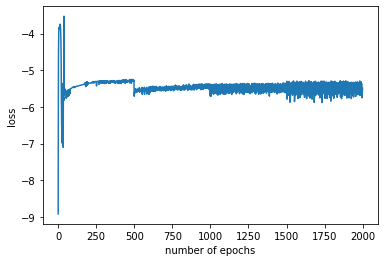

In [11]:
plt.plot(np.arange(num_epochs),l_set)# s = 0.1
#plt.ylim((52,53))
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.show() 

In [12]:
# Numerial: check accuracy of predicted fair individual allocation, with test data

output = torch.tensor([], device="cuda")
l_alpha = 0.0
l = 0.0
for i, data in enumerate(testloader, 0):
  testinput = data[0]
  testoutput = net(testinput.float())  
  testZ = generator(testinput.float())
  loss_alpha = gen_criterion(testoutput,testZ)
  loss = criterion(testinput,testoutput,loss_alpha)
  l_alpha += loss_alpha.item()
  l += loss.item()
  output = torch.cat([output,testoutput])
print('Estimated alpha: ', -l_alpha/(i+1))
print("Testing loss(-rho): {:.3f}".format(l / (i+1)))

print("From numerical, mean is ",torch.mean(output) )


Estimated alpha:  -13.625321550369263
Testing loss(-rho): -6.117
From numerical, mean is  tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)


**Compare $E_Q[Y^n]$**

In [13]:
## Copy from learning for risk measures.... train NN to get Y's
# Neural Networks
class Net_Y(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim):
        '''
        input_dim: how many variables are in the dataset, i.e. n_institutions 
        hidden_dim: list of hidden layer dimensions
        output_dim: number of classes i.e. n_institutions 
        '''
        super(Net_Y, self).__init__()
        # an affine operation: y = Wx + b
        model = [nn.Linear(input_dim, hidden_dim[0])]
        for i in range(len(hidden_dim)-1):
          model.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
        model.append(nn.Linear(hidden_dim[-1], output_dim))
        self.model = nn.ModuleList(model)   
        

    def forward(self, x):
        '''
        Use ReLU nonlinearities in the layers, and nothing at the output.
        '''
        for i in range(len(self.model)-1):
          x = torch.sigmoid(self.model[i](x))
        
        x=torch.log(1+torch.exp(self.model[-1](x))) ## different, nonnegativity of Y
        return x

class Loss_Y(nn.Module):
    def __init__(self, utility,u_paramaters, B, lam, mu):
        """
        input:
            utility function: 'exp','...'
            parameter for utitlity function: list of u_paramaters
        """
        super(Loss_Y, self).__init__()
        self.u = utility
        self.u_parameters = torch.tensor(u_paramaters, device="cuda")
        self.B, self.lam, self.mu  = B, lam, mu
        
    def calculate_u(self, x):
        if self.u == 'exp':
          return torch.sum(-torch.exp(-x*self.u_parameters)/self.u_parameters, dim=1)
        
    def forward(self, X, Y):
        """
        input:
            X -- inputs: M x N
            Y -- outputs: M x N
        return: value of loss function
        """
        M = X.size(dim=0)
        # control lost
        sum_Y = torch.sum(Y, 1)
        sum_u = self.calculate_u(X+Y)
        
        self.term1 = self.B - torch.mean(sum_u)
        self.term2 = torch.var(sum_Y)
        self.term3 = torch.mean(sum_Y)
        self.term4 = torch.mean(sum_u)
        return torch.mean(sum_Y)  + self.mu*torch.std(sum_Y) + self.lam*torch.relu(self.B - torch.mean(sum_u))#**2


    def print_loss(self):
        print("B-sum u_n",self.term1.item(),"\nsum u_n(Xn+Yn)",self.term4.item(), "\nvar(sumY)",self.term2.item(), "\nmean(sumY)", self.term3.item())

utility, B, lam, mu = 'exp',B, 2, 2.  ######10,5

input_dim= n_institutions     # how many Variables are in the dataset
hidden_dim = [64,64]          # hidden layer dimensions
output_dim= n_institutions   # number of classes

In [14]:
## Instantiating the classifier
net_Y = Net_Y(input_dim,hidden_dim ,output_dim).to(device)
criterion_Y = Loss_Y(utility,u_parameters, B, lam, mu)
learning_rate = 0.001#0.0001
optimizer = optim.SGD(net_Y.parameters(), lr=learning_rate, weight_decay=0.0001)

## 3. Training the neural network model
num_epochs = 3000

l_set = []
for j in range(1):
  print("Net {}".format(j+1))
  error_rate_paths=[[],[]]
  start_time = time.time()
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      if (epoch+1) % 1000 == 0 and epoch+1<num_epochs:
        optimizer.param_groups[0]['lr'] /= 5
        criterion_Y.lam *= 5
        criterion_Y.mu *= 5

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [N-dim inputs]
          input = data[0]
          # zero the parameter gradients, before each instance
          optimizer.zero_grad()
          # forward + backward + optimize
          output_tmp = net_Y(input.float())
          loss = criterion_Y(input, output_tmp)
          #print(loss.item())
          loss.backward()
          optimizer.step()    # Does the update

          # print statisticsç
          running_loss += loss.item()
      l_set.append(running_loss / (i+1))
      if epoch % 50 ==0:
        print("Epoch {}/{}, Training Loss: {:.3f}".format(epoch+1,num_epochs, running_loss / (i+1)))
  end_time = time.time()
  criterion_Y.print_loss()
  print('Finished Training for Net ',j+1)

  
print(f"training time is {(end_time-start_time)/60:.2f} minutes")

Net 1
Epoch 1/3000, Training Loss: 16.865
Epoch 51/3000, Training Loss: 6.770
Epoch 101/3000, Training Loss: 4.717
Epoch 151/3000, Training Loss: 4.620
Epoch 201/3000, Training Loss: 4.566
Epoch 251/3000, Training Loss: 4.516
Epoch 301/3000, Training Loss: 4.453
Epoch 351/3000, Training Loss: 4.363
Epoch 401/3000, Training Loss: 4.242
Epoch 451/3000, Training Loss: 4.115
Epoch 501/3000, Training Loss: 4.026
Epoch 551/3000, Training Loss: 3.984
Epoch 601/3000, Training Loss: 3.966
Epoch 651/3000, Training Loss: 3.955
Epoch 701/3000, Training Loss: 3.946
Epoch 751/3000, Training Loss: 3.938
Epoch 801/3000, Training Loss: 3.930
Epoch 851/3000, Training Loss: 3.922
Epoch 901/3000, Training Loss: 3.914
Epoch 951/3000, Training Loss: 3.905
Epoch 1001/3000, Training Loss: 9.958
Epoch 1051/3000, Training Loss: 6.259
Epoch 1101/3000, Training Loss: 6.062
Epoch 1151/3000, Training Loss: 5.931
Epoch 1201/3000, Training Loss: 5.833
Epoch 1251/3000, Training Loss: 5.756
Epoch 1301/3000, Training Lo

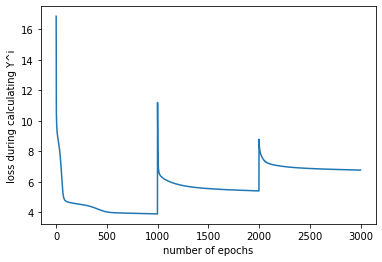

In [15]:
plt.plot(np.arange(num_epochs),l_set)# s = 0.1
#plt.ylim((52,53))
plt.xlabel('number of epochs')
plt.ylabel('loss during calculating Y^i')
plt.show()

In [23]:
Y_output = net_Y(testdata.float())
EQY_output = torch.mean(Y_output*output,0)
#print(np.mean(np.sum(EQY_output.detach().cpu().numpy(), dim=1))
print("E_Q [Y]\n",np.round(EQY_output.detach().cpu().numpy(), 3))


print(torch.mean(torch.sum(Y_output, dim=1)).item())

E_Q [Y]
 [6.860e-01 5.520e-01 4.330e-01 2.000e-03 1.000e-03 2.000e-03 2.609e+00
 1.971e+00 1.000e-03 1.000e-03]
5.972064971923828


In [24]:
np.sum(EQY_output.detach().cpu().numpy())

6.258441

In [ ]:
0.686 0.552 0.433 0.002 0.001 0.002 2.609 1.971 0.001 0.001